This notebook generates the figures for Chapter 5: Single-subject statistical analysis from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [1]:
import os,sys,shutil
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from statsmodels.tsa.arima_process import arma_generate_sample

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
%load_ext rpy2.ipython

datadir=os.getenv('FMRIBOOKDATA')
if not datadir:
    raise Exception('You need to set the environment variable FMRIBOOKDATA')
else:
    print 'using base dir:',datadir
sys.path.append('../../utils')

from get_data import get_data
data=get_data()

orig_figuredir='https://web.stanford.edu/group/poldracklab/fmri-handbook-2e-data/figures-1e/'

figuredir='../../figures'
if not os.path.exists(figuredir):
    os.mkdir(figuredir)

using base dir: /Users/poldrack/data/fmri-handbook-2e-data


__Figure 5.1__: Illustration of BOLD timeseries against boxcar.  _NOTE_: Fix error in caption in book

In [2]:
data=numpy.loadtxt(os.path.join(datadir,'filt_func_block_27_8_15.txt'))

stim=numpy.zeros((data.shape[0],1))
for i in range(10,data.shape[0],20):
    stim[i:i+10,0]=1
X=numpy.hstack((stim - numpy.mean(stim),numpy.ones((data.shape[0],1))))
bhat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data.T)
pred=X.dot(bhat)

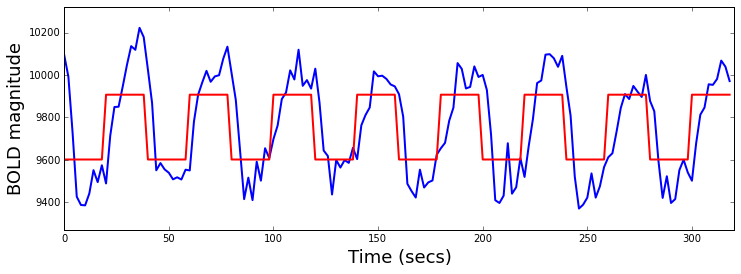

In [3]:
plt.figure(figsize=(12,4))
timepoints=numpy.arange(data.shape[0])*2.0
plt.plot(timepoints,data,linewidth=2)
plt.axis([0,data.shape[0]*2,numpy.min(data)-100,numpy.max(data)+100])
plt.plot(timepoints,pred,color='red',linewidth=2)
plt.ylabel('BOLD magnitude',fontsize=18)
plt.xlabel('Time (secs)',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_5_1.svg'),format='svg',dpi=1200)

__Figure 5.2__: use original manually generated image

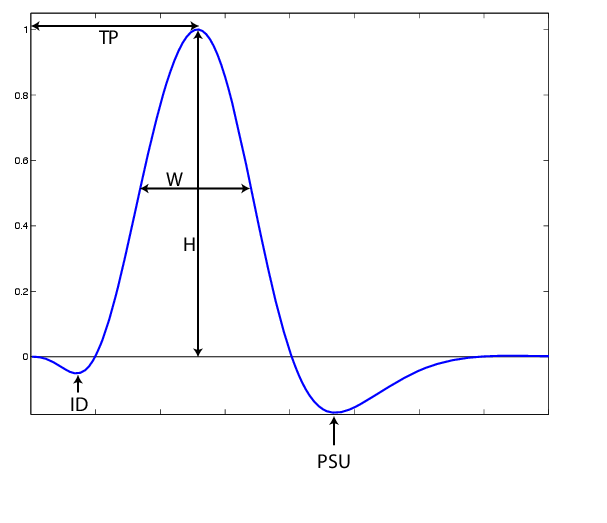

In [4]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_2.pdf'))

__Figure 5.3__: Examples of linear time invariance.  _NOTE_: add full color description to caption in book

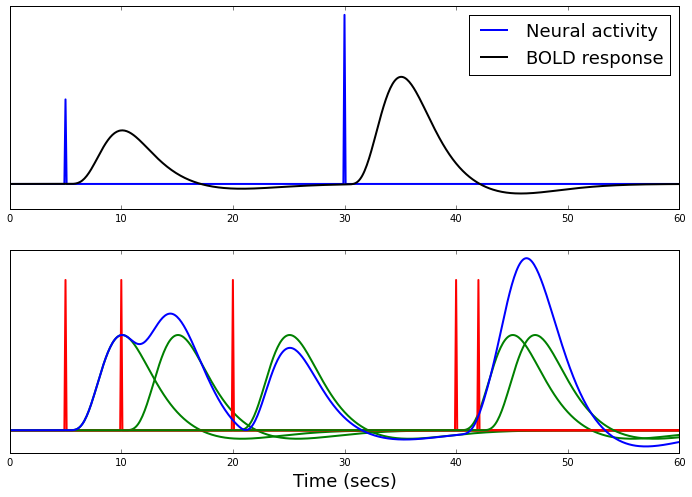

In [5]:
tr=0.1
tslen=60 # secs
ts=numpy.zeros(tslen/tr)
ts[numpy.round(5/0.1)]=1
ts[numpy.round(30/0.1)]=2
tsconv=numpy.convolve(ts,spm_hrf(tr,oversampling=1))[:len(ts)]

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
timepoints=numpy.arange(0,60,tr)
plt.plot(timepoints,ts/30.,linewidth=2)
plt.plot(timepoints,tsconv,color='black',linewidth=2)
plt.legend(['Neural activity','BOLD response'],fontsize=18)
plt.yticks([])
plt.subplot(2,1,2)

stimtimes=[5,10,20,40,42]
tsconv_sum=numpy.zeros(ts.shape)
for s in stimtimes:
    ts=numpy.zeros(tslen/tr)
    ts[s/tr]=1
    tsconv=numpy.convolve(ts,spm_hrf(tr,oversampling=1))[:len(ts)]
    tsconv_sum+=tsconv
    plt.plot(timepoints,ts/30.,linewidth=2,color='red')

    plt.plot(timepoints,tsconv,color='green',linewidth=2)

plt.plot(timepoints,tsconv_sum,linewidth=2,color='blue')
plt.xlabel('Time (secs)',fontsize=18)
plt.yticks([])
plt.savefig(os.path.join(figuredir,'Figure_5_3.svg'),format='svg',dpi=1200)

__Figure 5.4__: Example of selective averaging

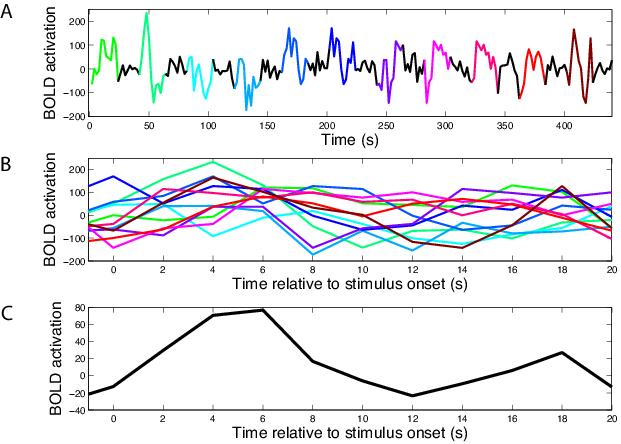

In [6]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_4.pdf'))


(1, 460)


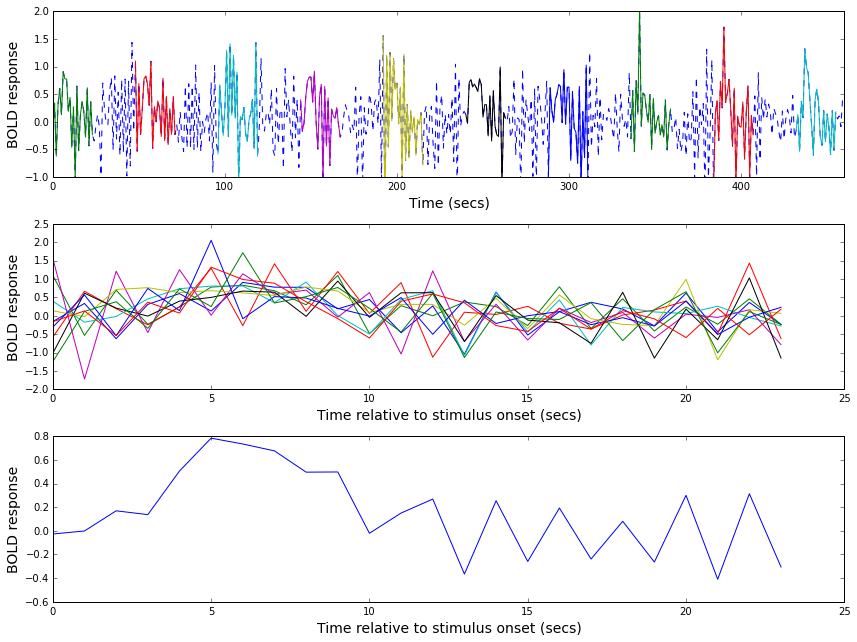

In [56]:
# generate simulated single-trial data
tslen=460
times=numpy.arange(0,tslen,48)
design=(times,numpy.ones(times.shape),numpy.ones(times.shape))
regressor,_=compute_regressor(design,'spm',numpy.arange(0,tslen))

ar1_noise=arma_generate_sample([1,0.6],[1,0.],len(regressor))
beta=4
y=regressor.T*beta + ar1_noise*0.4
print y.shape
plt.figure(figsize=(12,9))
plt.subplot(3,1,1)
plt.axis([0,tslen,-1.,2.])
plt.plot(y.T,'--')
plt.xlabel('Time (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
trialdata=None
for i in design[0]:
    plt.plot(numpy.arange(i,i+24),y.T[i:i+24])
    try:
        trialdata=numpy.hstack((trialdata,y.T[i:i+24]))
    except:
        trialdata=y.T[i:i+24]
        
plt.subplot(3,1,2)
plt.plot(trialdata)
plt.xlabel('Time relative to stimulus onset (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
plt.subplot(3,1,3)
plt.plot(numpy.mean(trialdata,1))
plt.xlabel('Time relative to stimulus onset (secs)',fontsize=14)
plt.ylabel('BOLD response',fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_4.svg'),format='svg',dpi=1200)

__Figure 5.5__: Example of different basis functions fit to a block design response

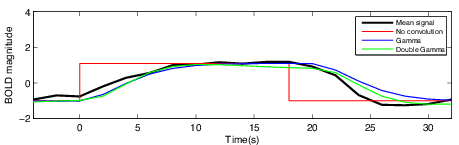

In [8]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_5.pdf'))


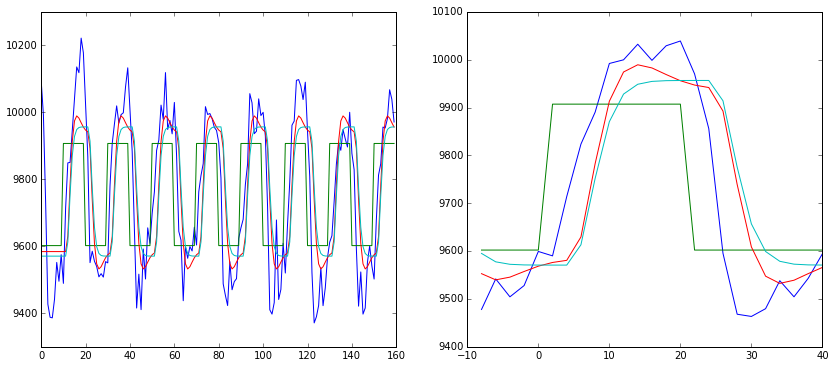

In [9]:
data=numpy.loadtxt(os.path.join(datadir,'filt_func_block_27_8_15.txt'))
boxcar=numpy.zeros(len(data))
onsets=[10, 30, 50, 70, 90, 110, 130, 150]  # in TRs
for i in onsets:
    boxcar[i:i+10]=1

conv_spm=numpy.convolve(boxcar,spm_hrf(2,1))[:len(data)]

from scipy.stats import gamma
# adapted from nipy.modalities.fmri.hemodynamic_models
def gamma_hrf(tr, oversampling=16, time_length=32., onset=0.,
                         delay=6, undershoot=16., dispersion=1.,
                         u_dispersion=1.):
    """ Compute an hrf as the difference of two gamma functions
    Parameters
    ----------
    tr: float, scan repeat time, in seconds
    oversampling: int, temporal oversampling factor, optional
    time_length: float, hrf kernel length, in seconds
    onset: float, onset of the hrf
    Returns
    -------
    hrf: array of shape(length / tr * oversampling, float),
         hrf sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = numpy.linspace(0, time_length, float(time_length) / dt)
    time_stamps -= onset / dt
    hrf = gamma.pdf(time_stamps, delay / dispersion, dt / dispersion) 
    hrf /= hrf.sum()
    return hrf

conv_gamma=numpy.convolve(boxcar,gamma_hrf(2,1))[:len(data)]

# fit models to data
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(data)
X_boxcar=numpy.hstack((boxcar.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_boxcar=numpy.linalg.inv(X_boxcar.T.dot(X_boxcar)).dot(X_boxcar.T.dot(data))
pred_boxcar=X_boxcar.dot(beta_boxcar)
plt.plot(pred_boxcar)
X_spm=numpy.hstack((conv_spm.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_spm=numpy.linalg.inv(X_spm.T.dot(X_spm)).dot(X_spm.T.dot(data))
pred_spm=X_spm.dot(beta_spm)
plt.plot(pred_spm)
X_gamma=numpy.hstack((conv_gamma.T[:,numpy.newaxis],numpy.ones((len(data),1))))
beta_gamma=numpy.linalg.inv(X_gamma.T.dot(X_gamma)).dot(X_gamma.T.dot(data))
pred_gamma=X_gamma.dot(beta_gamma)
plt.plot(pred_gamma)

blockresp=None
blockresp_spm=None
blockresp_gamma=None
blockresp_boxcar=None

# get mean block response
for i in onsets[:-1]:
    try:
        blockresp=numpy.vstack((blockresp,data[(i-5):(i+20)]))
        blockresp_spm=numpy.vstack((blockresp_spm,pred_spm[(i-5):(i+20)]))
        blockresp_gamma=numpy.vstack((blockresp_gamma,pred_gamma[(i-5):(i+20)]))
        blockresp_boxcar=numpy.vstack((blockresp_boxcar,pred_boxcar[(i-5):(i+20)]))
    except:
        blockresp=data[i-5:i+20]
        blockresp_spm=pred_spm[i-5:i+20]
        blockresp_gamma=pred_gamma[i-5:i+20]
        blockresp_boxcar=pred_boxcar[i-5:i+20]
    
plt.subplot(1,2,2)
pst=numpy.arange(-8,42,2)
plt.plot(pst,numpy.mean(blockresp,0))
plt.plot(pst,numpy.mean(blockresp_boxcar,0))
plt.plot(pst,numpy.mean(blockresp_spm,0))
plt.plot(pst,numpy.mean(blockresp_gamma,0))

plt.savefig(os.path.join(figuredir,'Figure_5_5.svg'),format='svg',dpi=1200)

__Figure 5.6__: Example of temporal derivative (_NOTE_: time axis was incorrect in previous edition)

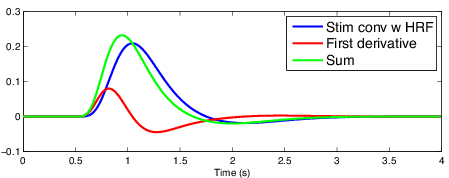

In [10]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_6.pdf'))


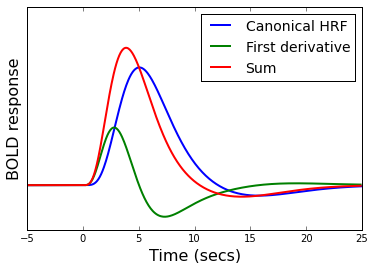

In [11]:
timepoints=numpy.arange(-5,25,1/16.)
ts=numpy.zeros(len(timepoints))
ts[16*5]=1
hrf=spm_hrf(1.)
tsconv=numpy.convolve(ts,hrf)[:len(ts)]
plt.plot(timepoints,tsconv,linewidth=2)
deriv=tsconv[1:]-tsconv[:-1]
plt.plot(timepoints[:-1],deriv*20,linewidth=2)
plt.plot(timepoints[:-1],tsconv[:-1]+deriv*20,linewidth=2)
plt.legend(['Canonical HRF','First derivative','Sum'],fontsize=14)
plt.xlabel('Time (secs)',fontsize=16)
plt.yticks([])
plt.ylabel('BOLD response',fontsize=16)
plt.savefig(os.path.join(figuredir,'Figure_5_6.svg'),format='svg',dpi=1200)

__Figure 5.7__: Example of FIR model: Use original manually generated figure


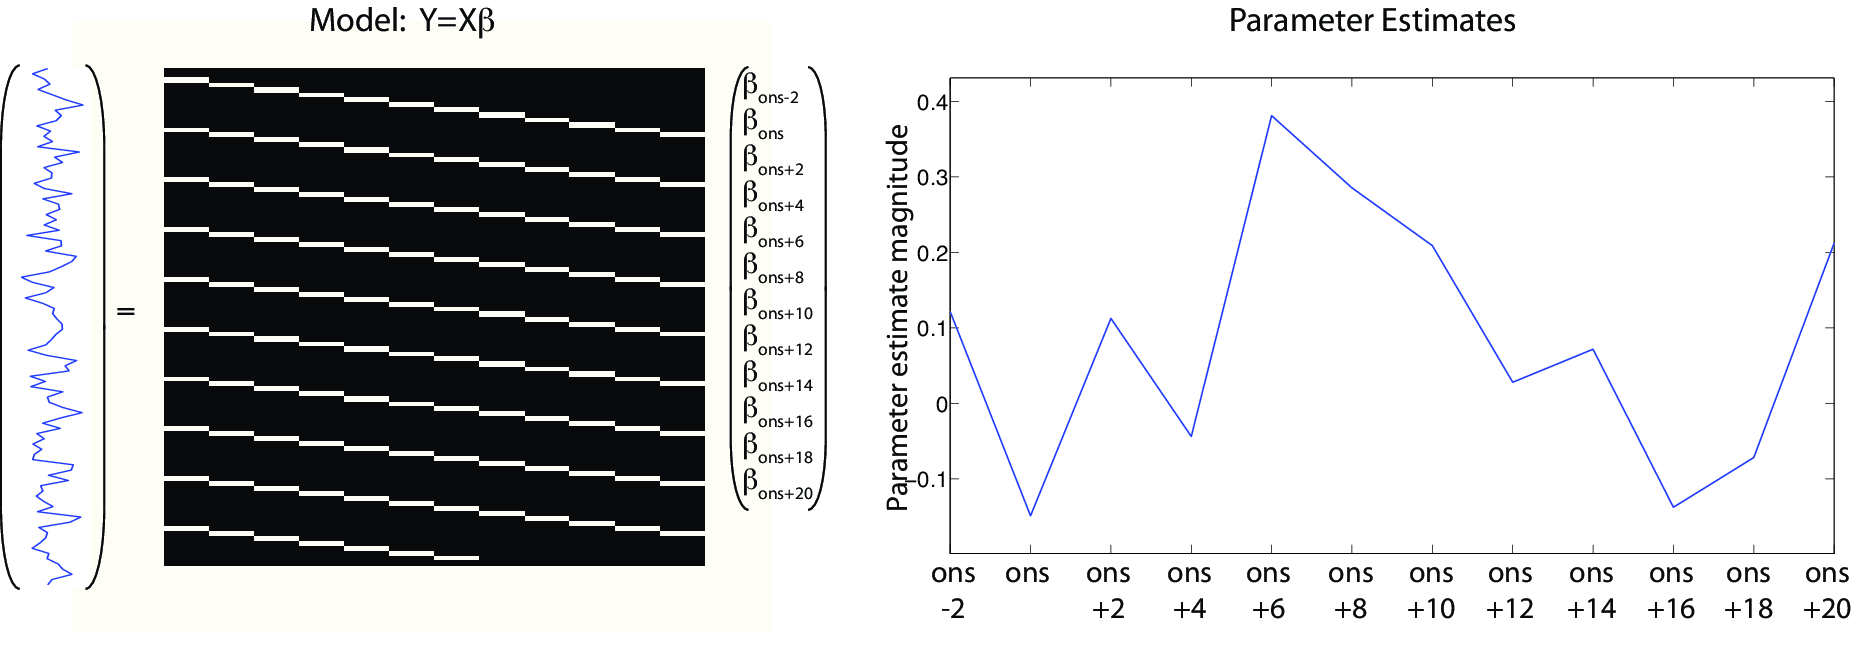

In [12]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_7.pdf'))


__Figure 5.8__: Example of FLOBS basis

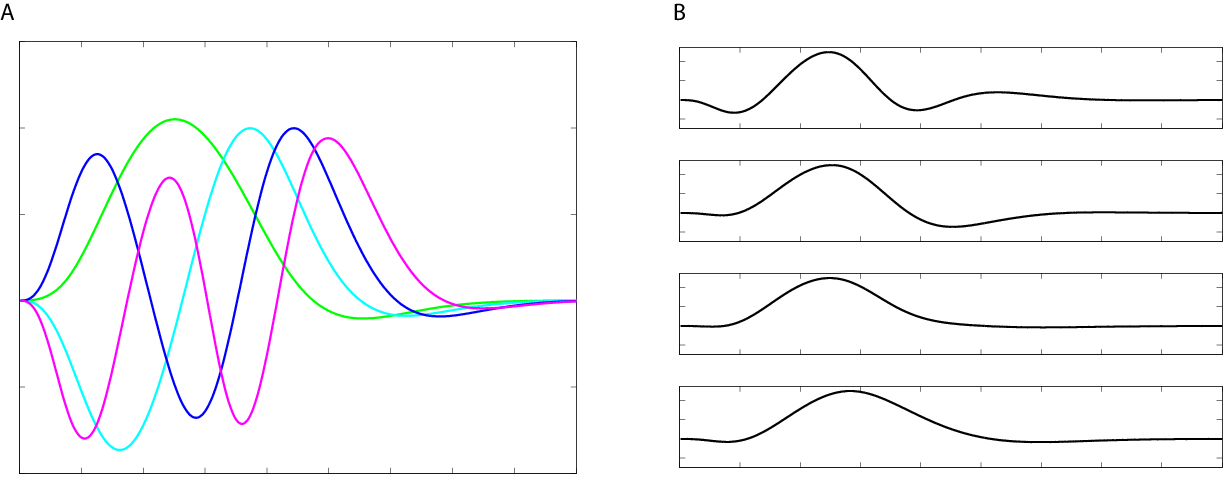

In [13]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_8.pdf'))


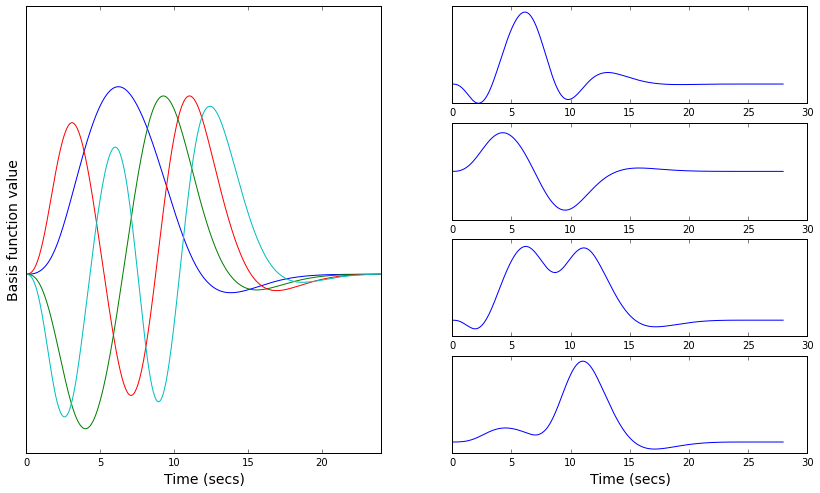

In [14]:
from __future__ import division
plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((4,2), (0,0), rowspan=4,colspan=1)
flobs=numpy.loadtxt(os.path.join(datadir,'hrfbasisfns.txt'))
plt.axis([0,24,-0.1,0.15])
timepoints=numpy.arange(0,28,28/flobs.shape[0])
plt.plot(timepoints,flobs)
plt.xlabel('Time (secs)', fontsize=14)
plt.yticks([])
plt.ylabel('Basis function value', fontsize=14)

fit1=numpy.array([0.1049,   -0.0263,   -0.0417,    0.0716])
ax2 = plt.subplot2grid((4,2), (0,1))
plt.plot(timepoints,flobs.dot(fit1))
plt.yticks([])
fit2=.8*numpy.array([0.1049,   -0.63,   -0.0417 ,   0.01])
ax3 = plt.subplot2grid((4,2), (1,1))
plt.plot(timepoints,flobs.dot(fit2))
plt.yticks([])
fit3=.4*numpy.array([0.5,   0.2263,   0.217,    0.2716])
ax4 = plt.subplot2grid((4,2), (2,1))
plt.plot(timepoints,flobs.dot(fit3))
plt.yticks([])
fit4=numpy.array([0.1,   0.15,   0.217,    0.1])
ax5 = plt.subplot2grid((4,2), (3,1))
plt.plot(timepoints,flobs.dot(fit4))
plt.yticks([])
plt.xlabel('Time (secs)', fontsize=14)
plt.savefig(os.path.join(figuredir,'Figure_5_8.svg'),format='svg',dpi=1200)

__Figure 5.9__: Example of fitting data with various basis sets

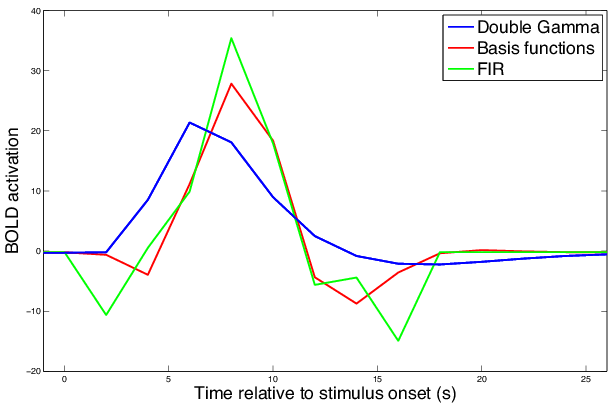

In [15]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_9.pdf'))



[ 0.49591813]


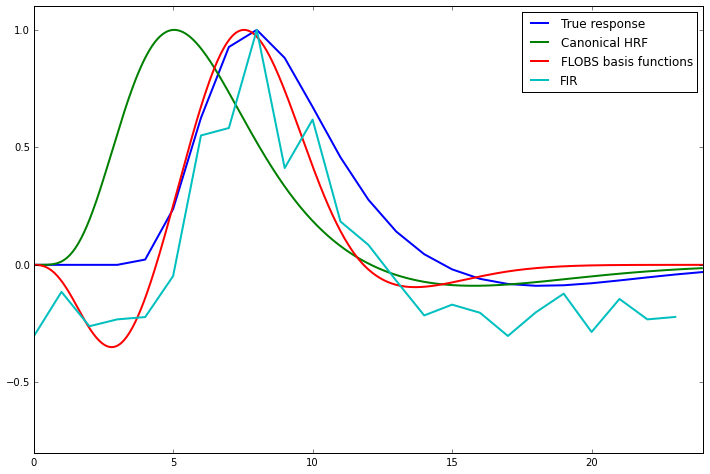

In [16]:
# first generate some data using a specific response shape
tslength=480
tr=1.
ts=numpy.zeros(tslength)
# make an evenly spaced event-related design
onsets=numpy.arange(10,tslength,24)  

def make_fir_model(onsets,tslength,hrflength=24,tr=1):
    """
    generate an FIR model design matrix
    """
    try:
        assert tr==1
    except:
        raise Exception('right now only works properly for tr==1, need to generalize')
        
    X=numpy.zeros((tslength,hrflength/tr))
    for i in range(hrflength):
        for o in onsets:
            try:
                X[o+i,i]=1
            except:
                pass
    return X

hrf=spm_hrf(1.,oversampling=1)
# shift the HRF by 2 secs to the right
hrf[2:]=hrf[:-2]
hrf[:2]=0

fir_X=make_fir_model(onsets,tslength)
data=fir_X.dot(hrf[:fir_X.shape[1]]) + arma_generate_sample([1,0.6],[1,0.],fir_X.shape[0])*0.1
data=data-numpy.mean(data) # demean so that we don't need a constant in the model

# fit the data using canonical, flobs, and FIR model
design=(onsets,numpy.ones(onsets.shape),numpy.ones(onsets.shape))
spmhrf_X,_=compute_regressor(design,'spm',numpy.arange(0,tslength))
spm_beta=numpy.linalg.lstsq(spmhrf_X,data)[0]
print spm_beta

fir_beta=numpy.linalg.lstsq(fir_X,data)[0]

# FLOBS is oversampled at 0.05 secs (20X)
flobs=numpy.loadtxt(os.path.join(datadir,'hrfbasisfns.txt'))

from nipy.modalities.fmri.hemodynamic_models import _sample_condition 
from scipy.interpolate import interp1d

sf_highres,hr_frametimes=_sample_condition(design,numpy.arange(0,tslength*tr,0.05),
                                            oversampling=1,min_onset=0)
frametimes=numpy.arange(0,tslength,1)

flobs_X=numpy.zeros((tslength,flobs.shape[1]))
for i in range(flobs.shape[1]):
    c=numpy.convolve(sf_highres,flobs[:,i])[:len(sf_highres)]
    f = interp1d(hr_frametimes, c)
    conv_lr=f(frametimes)
    flobs_X[:,i]=conv_lr
plt.figure(figsize=(12,8))
plt.plot(numpy.arange(0,32,1),hrf/numpy.max(hrf),label='True response',linewidth=2)
plt.axis([0,24,-0.8,1.1])

spm_resp=spm_hrf(1.,oversampling=20)[:480]
plt.plot(numpy.arange(0,24,0.05),spm_resp/numpy.max(spm_resp),label='Canonical HRF',linewidth=2)

flobs_beta=numpy.linalg.lstsq(flobs_X,data)[0]
flobs_resp=flobs.dot(flobs_beta)
plt.plot(numpy.arange(0,28,0.05),flobs_resp/numpy.max(flobs_resp),label='FLOBS basis functions',linewidth=2)

plt.plot(fir_beta/numpy.max(fir_beta),label='FIR',linewidth=2)
plt.legend()
plt.savefig(os.path.join(figuredir,'Figure_5_9.svg'),format='svg',dpi=1200)

__Figure 5.10__:  Comparison of convoultion in original time resolution and higher resolution

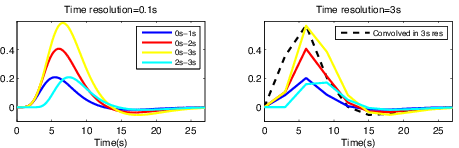

In [17]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_10.pdf'))


__Figure 5.11__: Construction of a parametrically modulated regressor

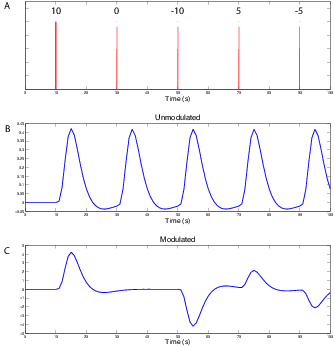

In [18]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_11.pdf'))


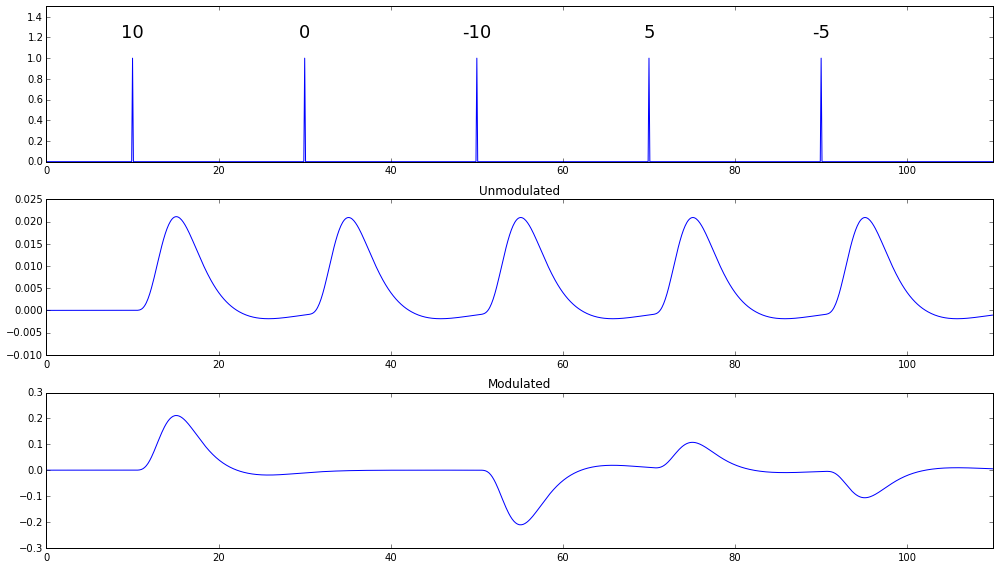

In [55]:
ts=numpy.zeros(1100)
timepoints=numpy.arange(0,110,0.1)
onsets=[100,300,500,700,900]
tr=0.1
ts[onsets]=1
parametric=[10,0,-10,5,-5]
tsp=numpy.zeros(1100)
tsp[onsets]=parametric

plt.figure(figsize=(14,8))
plt.subplot(3,1,1)
plt.plot(timepoints,ts)
plt.axis([0,110,0,1.5])
#plt.text(onsets*tr,1.2,'test')
for i in range(len(parametric)):
    plt.text(onsets[i]*tr,1.2,'%d'%parametric[i],fontsize=18,horizontalalignment='center')
    
plt.subplot(3,1,2)
hrf=spm_hrf(1.,oversampling=10)
conv=numpy.convolve(ts,hrf)
plt.plot(timepoints,conv[:len(timepoints)])
plt.axis([0,110,-0.01,0.025])
plt.title('Unmodulated')

plt.subplot(3,1,3)
hrf=spm_hrf(1.,oversampling=10)
conv=numpy.convolve(tsp,hrf)
plt.plot(timepoints,conv[:len(timepoints)])
plt.axis([0,110,-0.3,0.3])
plt.title('Modulated')

plt.tight_layout()
plt.savefig(os.path.join(figuredir,'Figure_5_11.svg'),format='svg',dpi=1200)

__Figure 5.12__: Example of orthogonalization

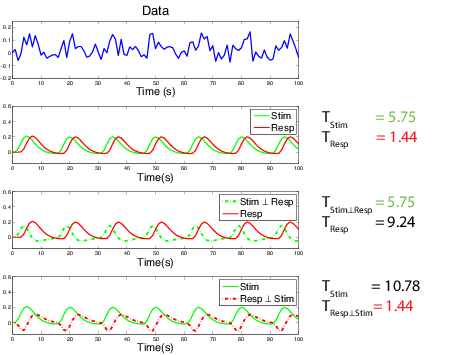

In [19]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_12.pdf'))


__Figure 5.13__: noise structure of fMRI data

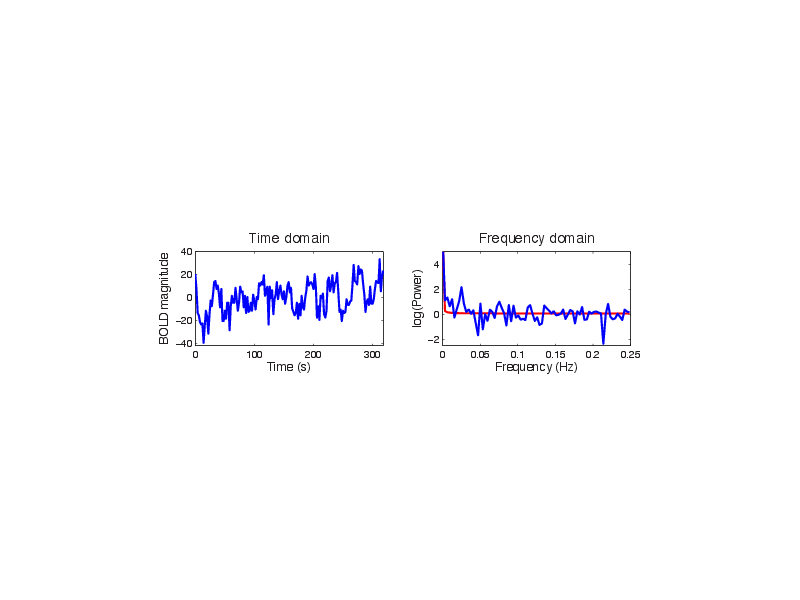

In [20]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_13.pdf'))


__Figure 5.14__: DCT basis set

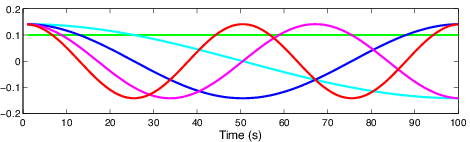

In [21]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_14.pdf'))


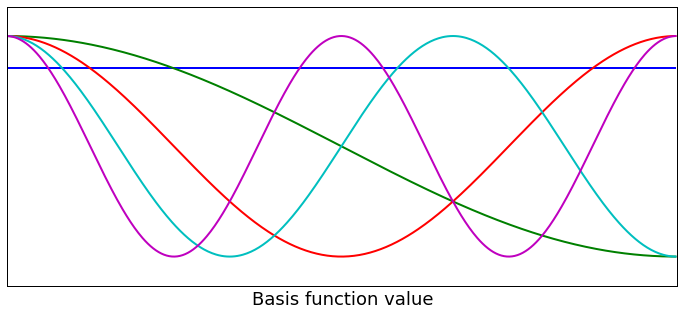

In [83]:
def spm_dctmtx(N,K):
    """ 
    implementation of spm_dctmtx.m (missing some options from original)
    N=dimension
    K=order
    """
    n=numpy.arange(0,N,1)
    C = numpy.zeros((len(n),K))
    C[:,0]     = numpy.ones(len(n))/numpy.sqrt(N)
    for k in range(1,K):
        C[:,k] = numpy.sqrt(2./float(N))*numpy.cos(numpy.pi*(2.*n+1)*(k)/(2.*N))

    return C

plt.figure(figsize=(12,5))
plt.plot(spm_dctmtx(500,5),linewidth=2)
plt.xticks([])
plt.yticks([])
plt.xlabel('Time',fontsize=18)
plt.xlabel('Basis function value',fontsize=18)
plt.savefig(os.path.join(figuredir,'Figure_5_14.svg'),format='svg',dpi=1200)

In [67]:
numpy.cos(numpy.pi*(2.*n+1)*(k-1)/float(2.*N))

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

__Figure 5.15__: Illustration of high-pass filtering

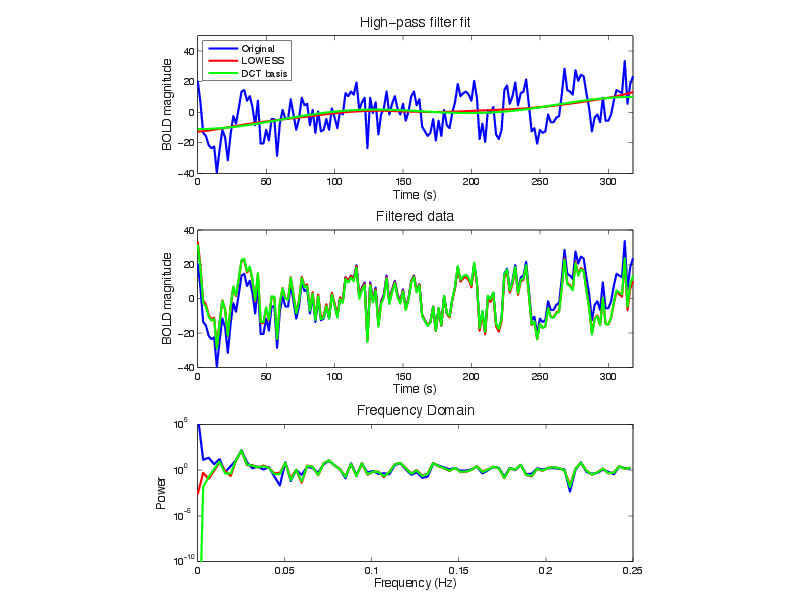

In [22]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_15.pdf'))


__Figure 5.16__: Illustration of different filtering approaches on blocked designs

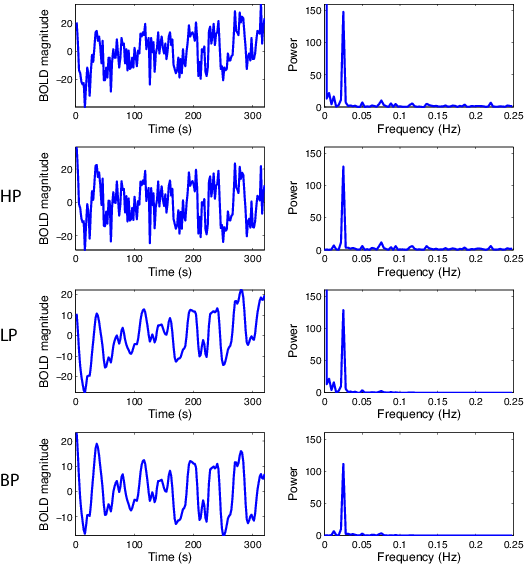

In [23]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_16.pdf'))


__Figure 5.17__: Illustration of different filtering approaches on blocked designs

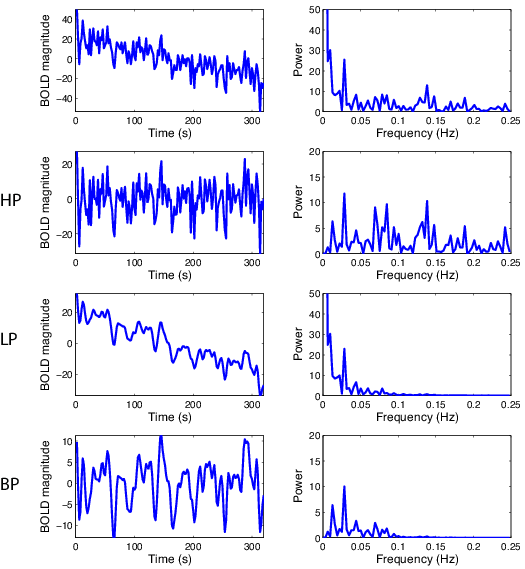

In [24]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_17.pdf'))


__Figure 5.18__: How jittering can improve model fit

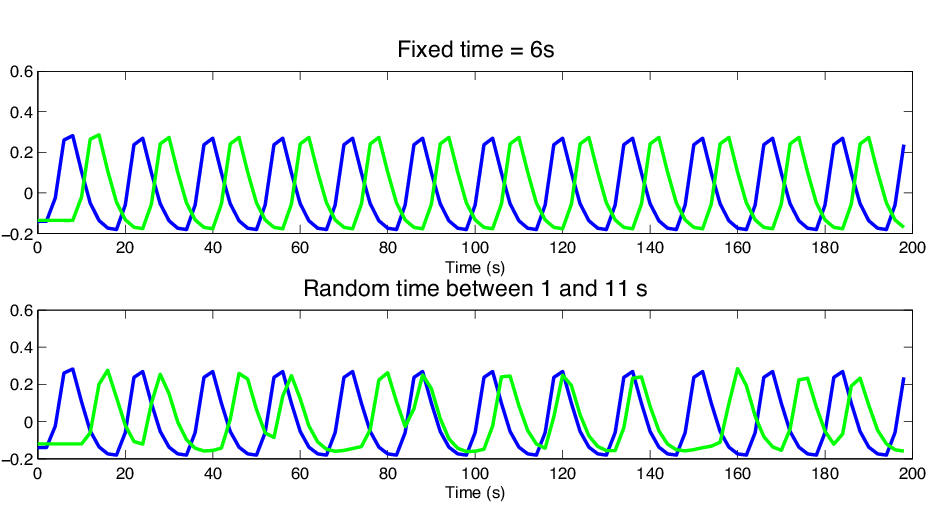

In [25]:
WImage(filename=os.path.join(orig_figuredir,'Figure_5_18.pdf'))
